In [1]:
import pandas as pd
import numpy as np
import torch
import sys

sys.path.insert(0, '../../../src/')

from utils.script_utils import create_parser, create_data_
sys.path.insert(0, '../../../scripts/')
from softmargin_run_new import add_arg_parser
from epigen import epidemy_gen_new


In [2]:
seeds = np.arange(1,11).tolist()
lamb_res_nn = []
lamb_res_sib = []
list_lambs = [0.02, 0.04, 0.06]
for ll in list_lambs:
    num_conf = 1

    parser = create_parser()
    add_arg_parser(parser)
    args = parser.parse_args("")
    args.type_graph="RRG"

    args.N = 100
    args.d=10
    args.h = 3
    args.t_limit = 15 # Numbers of epoch of our epidemics spreading [0,1,...,T_limit-1]
    args.mu = 0.02 # probability of recovery
    args.p_edge = 1
    args.scale=2
    args.ninf_min=5
    path_dir = "./data"
    if path_dir == "not_setted":
        path_dir = type_graph
    list_contacts = {}
    data_={}
    INSTANCES = []
    args.lambda_ = ll # probability of infection

    for i_seed, seed in enumerate(seeds):
        print(f"\nSEED: {seed}")

        args.seed=seed
        args.num_conf=num_conf
        #print(args)
        temp, name_file, INSTANCE = create_data_(args, give_instance=True)
        print(str(INSTANCE))
        INSTANCES.append(INSTANCE)
        #Ns[cl] = int(max(temp["contacts"][:, 1]) + 1)
        list_contacts[seed] = temp["contacts"]
        data_[seed] = temp

    name_files_nn = {}
    Ns = [args.N]
    for i_seed, seed in enumerate(seeds):
        #print(f"\nSEED: {seed}")
        name_files_nn[seed] = {}
        for cl in range(len(Ns)):
            name_files_nn[seed][Ns[cl]] = {}
            name_file_init = path_dir + "/"
            #print(step, name_file_init)
            name_file_temp = name_file_init + f"eq_05_RRG_n_{Ns[cl]}_d_{args.d}_tlim_{args.t_limit}_lam_{args.lambda_}_mu_{args.mu}_s_{seed}_pe_{args.p_edge}"
            #name_file_temp += f"_{seed}"
            name_files_nn[seed][Ns[cl]] = name_file_temp

    name_files_sib = {}
    for i_seed, seed in enumerate(seeds):
        #print(f"\nSEED: {seed}")
        name_files_sib[seed] = {}
        for cl in range(len(Ns)):
            name_files_sib[seed][Ns[cl]] = {}
            name_file_init = path_dir + "/"
            #print(step, name_file_init)
            name_file_temp = name_file_init + f"N_{Ns[cl]}_d_{args.d}_h_{args.h}_T_{args.t_limit}_lam_{args.lambda_}_mu_{args.mu}_p_edge_{args.p_edge}"
            name_file_temp += f"_s_{seed}"
            name_files_sib[seed][Ns[cl]] = name_file_temp
                #print(name_file_temp)
    ress = {}
    for i_seed, seed in enumerate(seeds):
        print(f"SEED: {seed}")
        ress[seed] = {}
        for cl in range(len(Ns)):
            N_cl = Ns[cl]
            ress[seed][Ns[cl]] = []
            for instance_num in range(num_conf):
                #print(f" N: {N_cl} instance {instance_num}")
                ress[seed][Ns[cl]].append({})
    for i_seed, seed in enumerate(seeds):
        print(f"SEED: {seed}")
        for cl in range(len(Ns)):
            N_cl = Ns[cl]
            for instance_num in range(num_conf):
                ress[seed][N_cl][instance_num]["regressive"] = {}
                name_temp = name_files_nn[seed][N_cl] +"_" + str(instance_num)
                print(f"Read N: {N_cl} instance {instance_num} - {name_temp}")
                try:
                    ress[seed][N_cl][instance_num]["regressive"] = {}
                    ress[seed][N_cl][instance_num]["regressive"]["marginals"] = np.load(name_temp + "_margs.npz",
                                                                            "r+",
                                                                        allow_pickle=True,
                                                                        fix_imports=True)["marginals"]
                except:
                    print(f"  instance_num: {instance_num} NOT FOUND")
                try:
                    ress[seed][N_cl][instance_num]["regressive"]["run"] = pd.read_csv(name_temp + "_trace.gz")
                    #print(f"  instance_num: {instance_num}")
                except:
                    print(f"gz no found {name_temp + '.gz'}")
                    pass
                try:
                    '''ress[seed][N_cl][instance_num]["regressive"]["net"] = torch.load(name_temp + ".pt",
                                                                        map_location=device)
                    #ress[N_cl][instance_num]["regressive"]["net"].to(device)
                    ress[seed][N_cl][instance_num]["regressive"]["net"].device = device
                    for ll in ress[seed][N_cl][instance_num]["regressive"]["net"].sublayers:
                        for l in ll:
                            l.device=device
                    print(f"  NN net: {instance_num}")'''
                    pass
                except:
                    print(f"  NN net: {instance_num} NON FOUND")
    for i_seed, seed in enumerate(seeds):
        print(f"SEED: {seed}")
        for cl in range(len(Ns)):
            N_cl = Ns[cl]
            for instance_num in range(num_conf):
                print(f"Read N: {N_cl} instance {instance_num}")
                name_temp = name_files_sib[seed][N_cl] +"_" + str(instance_num)
                #name_temp = name_temp.replace("mu_0", "mu_0.0")
                ress[seed][N_cl][instance_num]["sib"] = {}
                try:
                    ress[seed][N_cl][instance_num]["sib"]["marginals"] = np.load(name_temp + "_sib_margs.npz",
                                                                            "r+",
                                                                        allow_pickle=True,
                                                                        fix_imports=True)["marginals"]
                    ress[seed][N_cl][instance_num]["sib"]["params"] = pd.read_csv(name_temp + "_params.gz")
                    #print("load SIB")
                except:
                    print(f"SIB not found {name_temp}")
    temp_params = {"lambda_sib":[], "lambda_nn":[], "mu_sib":[], "mu_nn":[]}
    mu=[]
    for cl in range(len(Ns)):
        for i_seed, seed in enumerate(seeds):
            for instance_num in range(num_conf):
                temp_params["lambda_sib"].append(ress[seed][Ns[cl]][instance_num]["sib"]["params"]["lambda"].iloc[-1])
                temp_params["lambda_nn"].append(ress[seed][N_cl][instance_num]["regressive"]["run"]["lamb"].iloc[-1])
                mu_sib = 1. - np.exp(-np.array(ress[seed][Ns[cl]][instance_num]["sib"]["params"]["mu"].iloc[-1]))
                temp_params["mu_sib"].append(mu_sib)
                temp_params["mu_nn"].append(ress[seed][N_cl][instance_num]["regressive"]["run"]["mu"].iloc[-1])
            #lambdas=pd.DataFrame(temp_params)
    lamb_res_nn.append(np.array(temp_params["lambda_nn"]))    
    lamb_res_sib.append(np.array(temp_params["lambda_sib"]))


SEED: 1
nodes:100, edges:500
number of contacts: 15000
Lim infected: 5, Lim max infected: 101
Num sources:  1
 Sources {17}
 # conf 1,mean infected: 33.0, mean recover: 2.0, max num infected: 33
0 (0.00%) epidemies refused

S:67, I:31, R:2
RRG_n_100_d_10_tlim_15_lam_0.02_mu_0.02_s_1_pe_1

SEED: 2
nodes:100, edges:500
number of contacts: 15000
Lim infected: 5, Lim max infected: 101
Num sources:  1
 Sources {7}

num_infected 5 < 5 (lim_infected)
 Sources {11}
 # conf 1,mean infected: 9.0, mean recover: 1.0, max num infected: 9
1 (50.00%) epidemies refused

S:91, I:8, R:1
RRG_n_100_d_10_tlim_15_lam_0.02_mu_0.02_s_2_pe_1

SEED: 3
nodes:100, edges:500
number of contacts: 15000
Lim infected: 5, Lim max infected: 101
Num sources:  1
 Sources {30}

num_infected 1 < 5 (lim_infected)
 Sources {75}

num_infected 1 < 5 (lim_infected)
 Sources {69}
 # conf 1,mean infected: 17.0, mean recover: 1.0, max num infected: 17
2 (66.67%) epidemies refused

S:83, I:16, R:1
RRG_n_100_d_10_tlim_15_lam_0.02_mu

/Users/ocadni/git/ann_results/nnepi-results/results/parameters/rrg/../../../src/utils/script_utils.py:295: UserWarning: SAVING FOLDER DOES NOT EXIST
  warnings.warn("SAVING FOLDER DOES NOT EXIST")


number of contacts: 15000
Lim infected: 5, Lim max infected: 101
Num sources:  1
 Sources {73}

num_infected 5 < 5 (lim_infected)
 Sources {4}
 # conf 1,mean infected: 15.0, mean recover: 0.0, max num infected: 15
1 (50.00%) epidemies refused

S:85, I:15, R:0
RRG_n_100_d_10_tlim_15_lam_0.02_mu_0.02_s_10_pe_1
SEED: 1
SEED: 2
SEED: 3
SEED: 4
SEED: 5
SEED: 6
SEED: 7
SEED: 8
SEED: 9
SEED: 10
SEED: 1
Read N: 100 instance 0 - ./data/eq_05_RRG_n_100_d_10_tlim_15_lam_0.02_mu_0.02_s_1_pe_1_0
SEED: 2
Read N: 100 instance 0 - ./data/eq_05_RRG_n_100_d_10_tlim_15_lam_0.02_mu_0.02_s_2_pe_1_0
SEED: 3
Read N: 100 instance 0 - ./data/eq_05_RRG_n_100_d_10_tlim_15_lam_0.02_mu_0.02_s_3_pe_1_0
SEED: 4
Read N: 100 instance 0 - ./data/eq_05_RRG_n_100_d_10_tlim_15_lam_0.02_mu_0.02_s_4_pe_1_0
SEED: 5
Read N: 100 instance 0 - ./data/eq_05_RRG_n_100_d_10_tlim_15_lam_0.02_mu_0.02_s_5_pe_1_0
SEED: 6
Read N: 100 instance 0 - ./data/eq_05_RRG_n_100_d_10_tlim_15_lam_0.02_mu_0.02_s_6_pe_1_0
SEED: 7
Read N: 100 instanc

/Users/ocadni/git/ann_results/nnepi-results/results/parameters/rrg/../../../src/utils/script_utils.py:295: UserWarning: SAVING FOLDER DOES NOT EXIST
  warnings.warn("SAVING FOLDER DOES NOT EXIST")


Lim infected: 5, Lim max infected: 101
Num sources:  1
 Sources {73}
 # conf 1,mean infected: 70.0, mean recover: 6.0, max num infected: 70
0 (0.00%) epidemies refused

S:30, I:64, R:6
RRG_n_100_d_10_tlim_15_lam_0.04_mu_0.02_s_10_pe_1
SEED: 1
SEED: 2
SEED: 3
SEED: 4
SEED: 5
SEED: 6
SEED: 7
SEED: 8
SEED: 9
SEED: 10
SEED: 1
Read N: 100 instance 0 - ./data/eq_05_RRG_n_100_d_10_tlim_15_lam_0.04_mu_0.02_s_1_pe_1_0
SEED: 2
Read N: 100 instance 0 - ./data/eq_05_RRG_n_100_d_10_tlim_15_lam_0.04_mu_0.02_s_2_pe_1_0
SEED: 3
Read N: 100 instance 0 - ./data/eq_05_RRG_n_100_d_10_tlim_15_lam_0.04_mu_0.02_s_3_pe_1_0
SEED: 4
Read N: 100 instance 0 - ./data/eq_05_RRG_n_100_d_10_tlim_15_lam_0.04_mu_0.02_s_4_pe_1_0
SEED: 5
Read N: 100 instance 0 - ./data/eq_05_RRG_n_100_d_10_tlim_15_lam_0.04_mu_0.02_s_5_pe_1_0
SEED: 6
Read N: 100 instance 0 - ./data/eq_05_RRG_n_100_d_10_tlim_15_lam_0.04_mu_0.02_s_6_pe_1_0
SEED: 7
Read N: 100 instance 0 - ./data/eq_05_RRG_n_100_d_10_tlim_15_lam_0.04_mu_0.02_s_7_pe_1_0
SEED:

/Users/ocadni/git/ann_results/nnepi-results/results/parameters/rrg/../../../src/utils/script_utils.py:295: UserWarning: SAVING FOLDER DOES NOT EXIST
  warnings.warn("SAVING FOLDER DOES NOT EXIST")


number of contacts: 15000
Lim infected: 5, Lim max infected: 101
Num sources:  1
 Sources {7}
 # conf 1,mean infected: 81.0, mean recover: 6.0, max num infected: 81
0 (0.00%) epidemies refused

S:19, I:75, R:6
RRG_n_100_d_10_tlim_15_lam_0.06_mu_0.02_s_2_pe_1

SEED: 3
nodes:100, edges:500
number of contacts: 15000
Lim infected: 5, Lim max infected: 101
Num sources:  1
 Sources {30}
 # conf 1,mean infected: 63.0, mean recover: 5.0, max num infected: 63
0 (0.00%) epidemies refused

S:37, I:58, R:5
RRG_n_100_d_10_tlim_15_lam_0.06_mu_0.02_s_3_pe_1

SEED: 4
nodes:100, edges:500
number of contacts: 15000
Lim infected: 5, Lim max infected: 101
Num sources:  1
 Sources {30}
 # conf 1,mean infected: 85.0, mean recover: 8.0, max num infected: 85
0 (0.00%) epidemies refused

S:15, I:77, R:8
RRG_n_100_d_10_tlim_15_lam_0.06_mu_0.02_s_4_pe_1

SEED: 5
nodes:100, edges:500
number of contacts: 15000
Lim infected: 5, Lim max infected: 101
Num sources:  1
 Sources {79}
 # conf 1,mean infected: 73.0, mean 

In [3]:
lamb_res_nn = np.array(lamb_res_nn)
lamb_res_sib = np.array(lamb_res_sib)

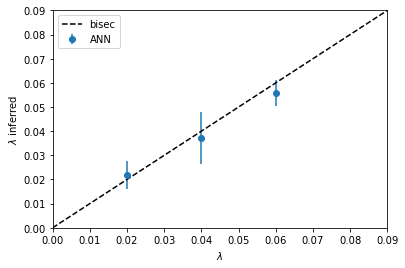

In [9]:
import matplotlib.pyplot as plt
plt.errorbar(list_lambs, lamb_res_nn.mean(axis=1), yerr = lamb_res_nn.std(axis=1), fmt="o",label="ANN")
#plt.errorbar(list_lambs, lamb_res_sib.mean(axis=1), yerr = lamb_res_nn.std(axis=1), fmt="o", label="SIB")
plt.plot([0,1], [0,1], "--", color="black", label="bisec")
plt.ylim(0,0.09)
plt.xlim(0,0.09)
plt.xlabel("$\lambda$")
plt.ylabel("$\lambda$ inferred")
plt.legend()
plt.savefig("infer_lam.pdf", dpi=300)

In [174]:
lamb_res_nn

array([[0.03233362, 0.01966662, 0.02539998, 0.01660035, 0.02019998,
        0.02539996, 0.01420631, 0.02833331, 0.01432547, 0.02366713],
       [0.05060182, 0.03740102, 0.01633364, 0.03059998, 0.03940137,
        0.02220832, 0.03580089, 0.04858914, 0.0456019 , 0.04580129],
       [0.06620116, 0.05233534, 0.04566901, 0.0545864 , 0.04940166,
        0.05966869, 0.05633518, 0.05740206, 0.05580175, 0.05980149]])

In [181]:
lamb_res_sib

array([[0.07542038, 0.06051086, 0.06539209, 0.04105671, 0.05118366,
        0.06526814, 0.07562908, 0.07603744, 0.05753805, 0.09736967],
       [0.07034873, 0.08503546, 0.01273892, 0.06863328, 0.10366791,
        0.05333627, 0.07935678, 0.08188206, 0.10531356, 0.07915471],
       [0.08053296, 0.06547111, 0.10304401, 0.0896845 , 0.08530161,
        0.08128187, 0.96540446, 0.09273031, 0.08571119, 0.06737079]])